In [1]:
import os
import fitsio
import desimodel
import astropy
import pandas                as     pd
import pylab                 as     pl
import numpy                 as     np
import astropy.io.fits       as     fits
import matplotlib.pyplot     as     plt

from   datetime              import datetime
from   astropy.table         import Table, vstack, join
from   astropy.coordinates   import Angle, SkyCoord
from   astropy               import units as u

from   desimodel.footprint   import is_point_in_desi
from   desimodel             import io
from   desitarget.geomask    import circles
from   desitarget.targetmask import desi_mask, obsconditions
from   astropy.coordinates   import SkyCoord
from   astropy.table         import Table
from   pathlib               import Path
from   desimodel.focalplane  import get_tile_radius_deg
from   tomog                 import select_tomog

In [2]:
np.random.seed(seed=314)

Potential addition: 'Stars were removed from the sample used to compute the number counts using SExtractor’s CLASS_STAR parameter with a threshold of 0.85'

In [3]:
def get_clauds(field='COSMOS', release='March2021', stellar_mask=True):
    fields           = ['COSMOS', 'DEEP_2', 'ELAIS', 'XMM_LSS']
    clauds           = {}
        
    assert field in fields
    assert field in ['COSMOS']
    
    areas            = {}
    areas['COSMOS']  = {'u': 4.41, 'uS': 4.20, 'g': 7.84,  'r': 7.84,  'i': 7.84,  'z': 7.84,  'y': 7.84}
    areas['XMM-LSS'] = {'u': 0.00, 'uS': 6.80, 'g': 6.38,  'r': 6.38,  'i': 6.38,  'z': 6.38,  'y': 6.38}
    areas['DEEP2-3'] = {'u': 3.70, 'uS': 0.00, 'g': 6.11,  'r': 6.11,  'i': 6.11,  'z': 6.11,  'y': 6.11}
    areas['ELAIS-N'] = {'u': 6.49, 'uS': 0.00, 'g': 10.68, 'r': 10.68, 'i': 10.68, 'z': 10.68, 'y': 10.68}

    if release == 'October2020':
        clauds[field] = Table.read('/global/cscratch1/sd/mjwilson/clauds/{}/{}_v3_v201026.fits'.format(release, field))
        
    elif release == 'February2021':
        clauds[field] = Table.read('/global/cscratch1/sd/mjwilson/clauds/{}/{}_v9_v210212.fits'.format(release, field))

    else:
        clauds[field] = Table.read('/global/cscratch1/sd/mjwilson/clauds/{}/{}_v9_v210225.fits'.format(release, field))
        
    if stellar_mask:
        # Bright star mask & has newer u band data: [HSC, u, Us, J, VirCAM, UDEEP] for FLAG_FIELD_BINARY (imaging_bit). 
        clauds[field] = clauds[field][(clauds[field]['MASK'] == 0)] 
    
    # u or uS data.
    inband           = (clauds[field]['FLAG_FIELD_BINARY'][:,1] == True) | (clauds[field]['FLAG_FIELD_BINARY'][:,2] == True)              

    clauds[field]    = clauds[field][inband]               

    # Randomise the rows for security. 
    indices          = np.arange(len(clauds[field]))
    randomised       = np.random.choice(indices, size=len(indices), replace=False)
    
    return  clauds[field][randomised], areas[field]

In [4]:
tile_radius  = get_tile_radius_deg()
tiles        = Table(io.load_tiles())

In [5]:
clauds, area = get_clauds(field='COSMOS', release='March2021')

In [6]:
# clauds.dtype.names

In [7]:
# Fix up fake magnitudes outside the observed areas.
clauds['u'][~clauds['FLAG_FIELD_BINARY'][:,1]]=0.
clauds['u_err'][~clauds['FLAG_FIELD_BINARY'][:,1]]=1000.
clauds['uS'][~clauds['FLAG_FIELD_BINARY'][:,2]]=0.
clauds['uS_err'][~clauds['FLAG_FIELD_BINARY'][:,2]]=1000.

In [8]:
clauds

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [7],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,FUV,NUV,u,uS,g,r,i,z,y,Yv,J,H,Ks,FUV_err,NUV_err,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,MAG_APER_3s_u,MAG_APER_3s_uS,MAG_APER_3s_g,MAG_APER_3s_r,MAG_APER_3s_i,MAG_APER_3s_z,MAG_APER_3s_y,MAG_APER_3s_Yv,MAG_APER_3s_J,MAG_APER_3s_H,MAG_APER_3s_Ks,MAGERR_APER_3s_u,MAGERR_APER_3s_uS,MAGERR_APER_3s_g,MAGERR_APER_3s_r,MAGERR_APER_3s_i,MAGERR_APER_3s_z,MAGERR_APER_3s_y,MAGERR_APER_3s_Yv,MAGERR_APER_3s_J,MAGERR_APER_3s_H,MAGERR_APER_3s_Ks,OFFSET_MAG_2s,OFFSET_MAG_3s,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,Z_BC03,ZPHOT,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,STAR_FORMING,NrK,IRX_NrK,LIR_NrK,SFR_NrK,VMAX_uS,VMAX_g,VMAX_r,VMAX_i,VMAX_Ks
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3089193,149.1918974537566,1.8890624585189224,9812,"2,2",0,7,True .. False,0.000118955526,9.602292e-05,4.0,-83.81825,1.2388394,0.19279283,0.016420276200781934,0.0003867239,25.003836,0.33737272,1.2088778,1.7729442,2.2688596,-99.0,-99.0,26.532,26.402,26.236,25.596,24.937,24.744,24.726,-99.02,-99.014,-99.009,-99.006,-99.0,-99.0,0.105,0.248,0.083,0.078,0.054,0.07,0.173,1000.0,1000.0,1000.0,1000.0,26.815,26.682514,26.500479,25.844463,25.173405,24.973274,24.951612,-99.0,-99.0,-99.0,-99.0,0.105407715,0.2479248,0.08294678,0.077941895,0.0541687,0.06970215,0.17297363,1000.0,1000.0,1000.0,1000.0,26.65738,26.428806,26.428753,25.661932,24.97279,24.756073,24.971132,-99.0,-99.0,-99.0,-99.0,0.13635254,0.29614258,0.11651611,0.0982666,0.06750488,0.085754395,0.26245117,1000.0,1000.0,1000.0,1000.0,-0.20410764406546952,-0.02700932227808353,2047.0,-15.552,-16.022,-16.899,-17.085,-17.657,-17.902,-18.152,-18.345,-18.443,-18.47,-18.549,-18.723,-18.555,-99.0,0.7066,0.5563,0.7694,11,0.312693,41.105,0.679891,28,68,29,0.6898,0.6029,0.7844,-99.0,0.22,0.6898,0.6898,5,640543000.0,0.3,1,996069000.0,8.65303,8.5934,8

In [9]:
# clauds.dtype.names

In [10]:
print(len(clauds) / 1.e6)

3.359344


In [11]:
# nomask, _ = get_clauds(field='COSMOS', release='February2021', stellar_mask=False)

In [12]:
# masked = ~ np.isin(nomask['ID'], clauds['ID'])
# masked = nomask[masked]

In [13]:
# len(nomask), len(clauds), len(masked)

In [14]:
# assert (3359344 + 624783) == len(nomask)

In [15]:
tomog = select_tomog(clauds, components=False)

# 12425 pre Vicent mag. fix
print(len(tomog))

Number of failures: 1564
12475


In [16]:
# masked_tomog = select_tomog(masked, components=False)
# print(len(masked_tomog) / 1.e4)

In [17]:
tomog.pprint()

   ID           RA         ...         uW                uW_err       
------- ------------------ ... ------------------ --------------------
2862416 149.45108189679198 ... 25.579727670539178 0.036418507911789064
2486372 150.84655164007873 ...  24.49390914479418    0.043999999957408
3530382 151.01308272256676 ... 25.217732094256508   0.0749999997890625
2723148 150.55991496086875 ... 24.830381365329988  0.01830510647543256
 234884 149.07316412702943 ... 27.945686771806205   0.7959997478209518
 826252  150.2307303766601 ... 26.131403209019325  0.09046161811773284
 817459 150.17385272605912 ... 26.034316195907497  0.07949362029097105
2706581  150.4810472141473 ...  25.39274472975188  0.02708581556471791
2445240 151.16904962054937 ... 27.567998113669773   0.2619999910076365
3046006  149.3553788319585 ... 25.323303985783546  0.02857894617342567
    ...                ... ...                ...                  ...
4666746  149.8269757446009 ...             28.528                4.312
166576

In [18]:
tomog.write('/global/cscratch1/sd/mjwilson/DESILBG/tomog/tomog.fits', format='fits', overwrite=True)

In [18]:
# masked_tomog.write('/global/cscratch1/sd/mjwilson/DESILBG/tomog/masked_tomog.fits', format='fits', overwrite=True)

Text(0, 0.5, '(uSc / uS) - 1')

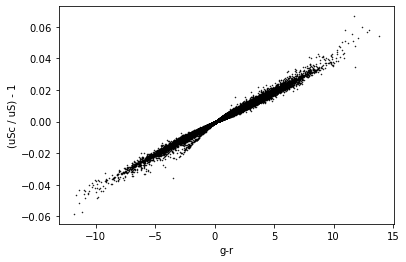

In [19]:
cut = (clauds['uS'] > 0.0) & (clauds['g'] > 0.0) & (clauds['r'] > 0.0)

pl.plot(clauds['g'][cut] - clauds['r'][cut], (clauds['uSc'][cut] / clauds['uS'][cut]) - 1.0, marker='.', lw=0.0, markersize=1, c='k')

pl.xlabel('g-r')
pl.ylabel('(uSc / uS) - 1')

In [20]:
tomog_lbg, tomog_lbg1, tomog_lbg2 = select_tomog(clauds, components=True)

# 0.7722 0.2219 0.2484
print(len(tomog_lbg) / 1.e4, len(tomog_lbg1) / 1.e4, len(tomog_lbg2) / 1.e4)

Number of failures: 7628
0.7722 0.2219 0.2484


In [21]:
# Old length: 2582606
tomog

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [7],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,FUV,NUV,u,uS,g,r,i,z,y,Yv,J,H,Ks,FUV_err,NUV_err,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,MAG_APER_3s_u,MAG_APER_3s_uS,MAG_APER_3s_g,MAG_APER_3s_r,MAG_APER_3s_i,MAG_APER_3s_z,MAG_APER_3s_y,MAG_APER_3s_Yv,MAG_APER_3s_J,MAG_APER_3s_H,MAG_APER_3s_Ks,MAGERR_APER_3s_u,MAGERR_APER_3s_uS,MAGERR_APER_3s_g,MAGERR_APER_3s_r,MAGERR_APER_3s_i,MAGERR_APER_3s_z,MAGERR_APER_3s_y,MAGERR_APER_3s_Yv,MAGERR_APER_3s_J,MAGERR_APER_3s_H,MAGERR_APER_3s_Ks,OFFSET_MAG_2s,OFFSET_MAG_3s,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,Z_BC03,ZPHOT,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,STAR_FORMING,NrK,IRX_NrK,LIR_NrK,SFR_NrK,VMAX_uS,VMAX_g,VMAX_r,VMAX_i,VMAX_Ks,uSc,uW,uW_err
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3426047,148.62842937293067,1.899344914451632,9812,"5,2",0,4,False .. False,0.0001248907,0.00011699899,4.0,-48.14717,1.067438,0.0631774,0.023887983732202887,0.00022957606,22.186396,0.97646904,1.0820869,1.5999894,2.0705996,-99.0,-99.0,-99.115,25.835,23.633,22.611,22.259,21.911,21.851,-99.029,-99.021,-99.013,-99.009,-99.0,-99.0,1000.0,0.122,0.032,0.013,0.018,0.013,0.032,1000.0,1000.0,1000.0,1000.0,-99.0,26.076603,23.849943,22.805305,22.435923,22.076569,22.011578,-99.0,-99.0,-99.0,-99.0,1000.0,0.12231445,0.031951904,0.012535095,0.018173218,0.012611389,0.03189087,1000.0,1000.0,1000.0,1000.0,-99.0,26.23213,23.750216,22.694122,22.251055,22.02316,21.896238,-99.0,-99.0,-99.0,-99.0,1000.0,0.2121582,0.042938232,0.016403198,0.022583008,0.017852783,0.044403076,1000.0,1000.0,1000.0,1000.0,-0.12979163731667687,-0.024188242336648347,2047.0,-8.96,-9.946,-13.572,-14.515,-15.872,-16.513,-16.938,-17.183,-17.36,-17.421,-17.525,-17.748,-17.51,-99.0,0.1343,0.12,0.1455,11,20.9431,9.85749,5.76952,2,104,2,0.1379,0.1212,0.1567,-99.0,3.04,0.1379,0.1379,1,9000000000.0,0.0,

In [22]:
print('Target density of tomog galaxies per sq. deg. is {:.2f}'.format(len(tomog) / area['u']))

Target density of tomog galaxies per sq. deg. is 2817.46


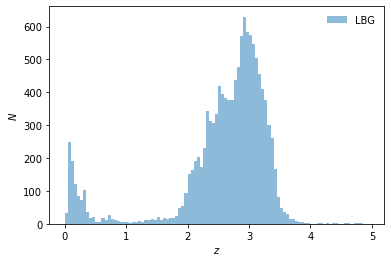

In [24]:
bins = np.arange(0.0, 5.0, 0.05)

pl.hist(tomog['Z_BC03'], bins=bins, alpha=0.5, label='LBG')

pl.xlabel(r'$z$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

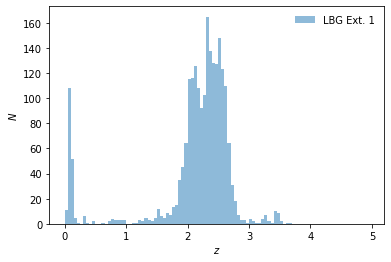

In [25]:
bins = np.arange(0.0, 5.0, 0.05)

pl.hist(tomog_lbg1['Z_BC03'], bins=bins, alpha=0.5, label='LBG Ext. 1')

pl.xlabel(r'$z$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

In [26]:
print(len(tomog_lbg1), np.count_nonzero(tomog_lbg1['Z_BEST'] < 1.5))

2219 380


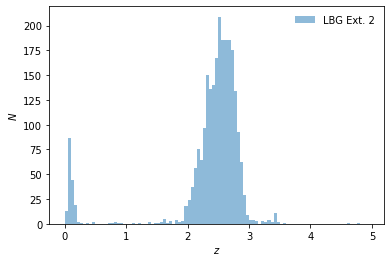

In [27]:
bins = np.arange(0.0, 5.0, 0.05)

pl.hist(tomog_lbg2['Z_BC03'], bins=bins, alpha=0.5, label='LBG Ext. 2')

pl.xlabel(r'$z$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

In [28]:
print(len(tomog_lbg2), np.count_nonzero(tomog_lbg2['Z_BEST'] < 1.5))

2484 320


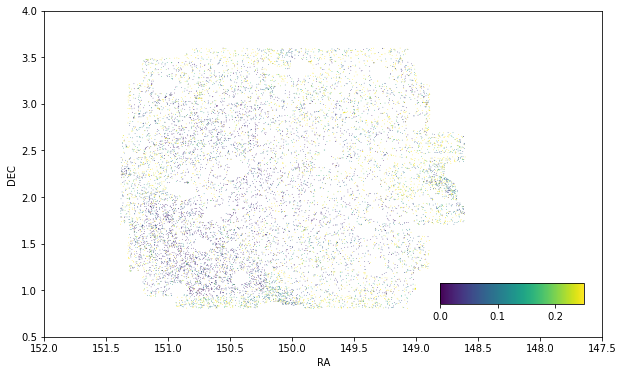

In [29]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(tomog['RA'], tomog['DEC'], c=tomog['uW_err'], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)
        
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

cax      = fig.add_axes([0.675, 0.2, 0.2, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

pl.savefig('plots/clauds_tomog_field.pdf')

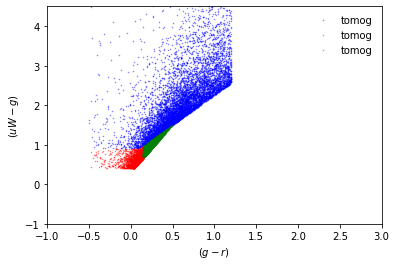

In [30]:
pl.plot( tomog_lbg['g'] - tomog_lbg['r'],   tomog_lbg['uW'] - tomog_lbg['g'],  marker='.', c='b', lw=0.0, label='tomog', alpha=0.5, markersize=1)
pl.plot(tomog_lbg1['g'] - tomog_lbg1['r'], tomog_lbg1['uW'] - tomog_lbg1['g'], marker='.', c='r', lw=0.0, label='tomog', alpha=0.5, markersize=1)
pl.plot(tomog_lbg2['g'] - tomog_lbg2['r'], tomog_lbg2['uW'] - tomog_lbg2['g'], marker='.', c='g', lw=0.0, label='tomog', alpha=0.5, markersize=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(uW-g)$')

pl.legend(frameon=False)

pl.savefig('plots/Feb21/clauds-tomog-selection.pdf')

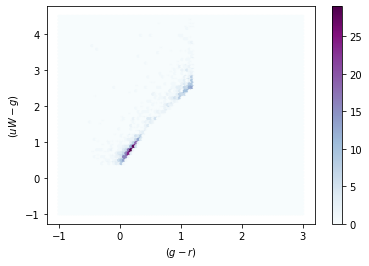

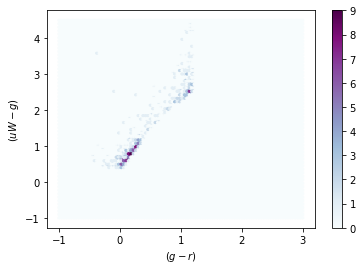

In [31]:
zmax  = 1.5

nocut = np.ones(len(tomog), dtype=bool)
cut   = (tomog['FLAG_FIELD_BINARY'][:,2] == True) & (tomog['FLAG_FIELD_BINARY'][:,1] == False)

for x in [nocut, cut]:
    interloper = tomog[x][tomog[x]['Z_BEST'] < zmax]

    # mincnt=10.0
    plt.hexbin(interloper['g'] - interloper['r'], interloper['uW'] - interloper['g'], extent=[-1., 3., -1., 4.5], cmap='BuPu')
    pl.colorbar()

    pl.xlabel(r'$(g -r)$')
    pl.ylabel(r'$(uW-g)$')
    pl.show()

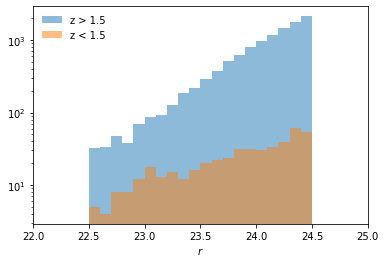

In [32]:
bins = np.arange(18., 26., 0.1)

interloper = tomog[tomog['Z_BEST'] < zmax]
high = tomog[tomog['Z_BEST'] > zmax]

cut  = (tomog['Z_BEST'] > zmax)
pl.hist(tomog['r'][cut], bins=bins, label='z > 1.5', alpha=0.5)

cut  = (interloper['FLAG_FIELD_BINARY'][:,2] == True) & (interloper['FLAG_FIELD_BINARY'][:,1] == False)
pl.hist(interloper['r'][cut], bins=bins, label='z < 1.5', alpha=0.5)

pl.xlim(22., 25.)

pl.yscale('log')
pl.xlabel(r'$r$')

pl.legend(frameon=False)

# Done.